In [50]:
import glob
import re
import xarray as xr
from cutshapefile import transform_from_latlon, rasterize
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import cartopy.feature as cfeature
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [27]:
emission_files = glob.glob('/nfs/b0122/Users/earlacoa/emissions/EDGAR-HTAP2_MEIC2015/MOZART/*nc')
emission_files = [emission_file for emission_file in emission_files if 'CH4' not in emission_file]

In [ ]:
shapefile = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_adm0.shp')
shapes = [(shape, index) for index, shape in enumerate(shapefile.geometry)]

In [98]:
emissions = {}

for emission_file in emission_files:
    specie = re.findall(r'MEIC2015_[A-Z]*[a-z]*[0-9]*.[A-Z]*[0-9]*[A-Z]*', emission_file)[0].split('_')[1]
    
    with xr.open_dataset(emission_file) as ds:
        if specie != 'NH3':
            for sector in ['RES', 'IND', 'TRA', 'ENE']:
                ds_jan = ds.isel(time=0)[f'emis_{sector.lower()}']
                
                ds_jan['shapefile'] = rasterize(shapes, ds_jan.coords, longitude='lon', latitude='lat') 
                ds_jan['shapefile'] = ds_jan.shapefile.where(cond=ds_jan.shapefile!=0, other=1)
                ds_jan_cropped = ds_jan.where(cond=ds_jan.shapefile==1, other=np.nan)
                
                emissions.update({f'{sector}_{specie}': ds_jan_cropped})
        elif specie == 'NH3':
            for sector in ['RES', 'IND', 'TRA', 'AGR', 'ENE']:
                ds_jan = ds.isel(time=0)[f'emis_{sector.lower()}']
                
                ds_jan['shapefile'] = rasterize(shapes, ds_jan.coords, longitude='lon', latitude='lat') 
                ds_jan['shapefile'] = ds_jan.shapefile.where(cond=ds_jan.shapefile!=0, other=1)
                ds_jan_cropped = ds_jan.where(cond=ds_jan.shapefile==1, other=np.nan)
                
                emissions.update({f'{sector}_{specie}': ds_jan_cropped})

In [182]:
emissions_all = {}

for emission_file in emission_files:
    specie = re.findall(r'MEIC2015_[A-Z]*[a-z]*[0-9]*.[A-Z]*[0-9]*[A-Z]*', emission_file)[0].split('_')[1]
    
    with xr.open_dataset(emission_file) as ds:
        if specie != 'NH3':
            for sector in ['RES', 'IND', 'TRA', 'ENE']:
                ds_jan = ds.isel(time=0)[f'emis_{sector.lower()}']
                              
                emissions_all.update({f'{sector}_{specie}': ds_jan})
        elif specie == 'NH3':
            for sector in ['RES', 'IND', 'TRA', 'AGR', 'ENE']:
                ds_jan = ds.isel(time=0)[f'emis_{sector.lower()}']
                
                emissions_all.update({f'{sector}_{specie}': ds_jan})

In [53]:
lat = ds.lat.values
lon = ds.lon.values

xx, yy = np.meshgrid(lon, lat)

In [147]:
titles = {'BC': 'BC', 'OC': 'OC', 'PM2.5': 'PM$_{2.5}$', 'PM10': 'PM$_{10}$', 'CO': 'CO', 'NH3': 'NH$_{3}$', 'NOx': 'NO$_{X}$', 'SO2': 'SO$_{2}$', 'VOC': 'VOC'}

In [223]:
levels_sectors_species = {
    'RES_BC': np.linspace(0, 1e-11, 11),
    'IND_BC': np.linspace(0, 1e-11, 11),
    'TRA_BC': np.linspace(0, 1e-11, 11),
    'ENE_BC': np.linspace(0, 1e-11, 11),
    'RES_OC': np.linspace(0, 1e-11, 11),
    'IND_OC': np.linspace(0, 1e-11, 11),
    'TRA_OC': np.linspace(0, 1e-11, 11),
    'ENE_OC': np.linspace(0, 1e-11, 11),
    'RES_PM2.5': np.linspace(0, 1e-10, 11),
    'IND_PM2.5': np.linspace(0, 1e-10, 11),
    'TRA_PM2.5': np.linspace(0, 1e-10, 11),
    'ENE_PM2.5': np.linspace(0, 1e-10, 11),
    'RES_PM10': np.linspace(0, 1e-10, 11),
    'IND_PM10': np.linspace(0, 1e-10, 11),
    'TRA_PM10': np.linspace(0, 1e-10, 11),
    'ENE_PM10': np.linspace(0, 1e-10, 11),    
    'RES_CO': np.linspace(0, 1e-9, 11),
    'IND_CO': np.linspace(0, 1e-9, 11),
    'TRA_CO': np.linspace(0, 1e-9, 11),
    'ENE_CO': np.linspace(0, 1e-9, 11),
    'RES_NH3': np.linspace(0, 1e-10, 11),
    'IND_NH3': np.linspace(0, 1e-10, 11),
    'TRA_NH3': np.linspace(0, 1e-10, 11),
    'AGR_NH3': np.linspace(0, 1e-10, 11),
    'RES_NOx': np.linspace(0, 1e-10, 11),
    'IND_NOx': np.linspace(0, 1e-10, 11),
    'TRA_NOx': np.linspace(0, 1e-10, 11),
    'ENE_NOx': np.linspace(0, 1e-10, 11),
    'RES_SO2': np.linspace(0, 1e-10, 11),
    'IND_SO2': np.linspace(0, 1e-10, 11),
    'TRA_SO2': np.linspace(0, 1e-10, 11),
    'ENE_SO2': np.linspace(0, 1e-10, 11),
    'RES_VOC': np.linspace(0, 1e-9, 11),
    'IND_VOC': np.linspace(0, 1e-9, 11),
    'TRA_VOC': np.linspace(0, 1e-9, 11),
    'ENE_VOC': np.linspace(0, 1e-9, 11),
}

In [221]:
def make_plot(index, emissions, sector, specie, region):
    ax = fig.add_subplot(gs[index], projection=ccrs.PlateCarree())
    plt.annotate(r'\textbf{(' + chr(index + 97) + ')}', xy=(0,1.05), xycoords='axes fraction', fontsize=14)
    
    ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
    if region == 'China':
        shape_feature = ShapelyFeature(
            Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_0.shp').geometries(),                             
            ccrs.PlateCarree(), 
            facecolor='none'
        )
        shape2_feature = ShapelyFeature(
            Reader('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_1.shp').geometries(),                             
            ccrs.PlateCarree(), 
            facecolor='none'
        )
        ax.patch.set_visible(False)
        ax.spines['geo'].set_visible(False)
        ax.add_feature(shape_feature, edgecolor='black', linewidth=0.5)
        ax.add_feature(shape2_feature, edgecolor='black', linewidth=0.3)
    elif region == 'all':
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, edgecolor='black')
    
    if specie != 'VOC':
        emission = emissions[f'{sector}_{specie}']
    else:
        for number_voc, individual_voc in enumerate(['CH3OH', 'CH3CHO', 'C2H6', 'XYLENE', 'C2H5OH', 'C3H8', 'C3H6', 'MEK', 'BENZENE', 'BIGALK', 'C2H4', 'BIGENE', 'CH3COCH3', 'CH2O', 'TOLUENE']):
            if number_voc == 0:
                emission = emissions[f'{sector}_{individual_voc}']
            else:
                emission += emissions[f'{sector}_{individual_voc}']
    
    cmap = 'viridis'
    levels = levels_sectors_species[f'{sector}_{specie}']
    norm = matplotlib.colors.Normalize(vmin=levels[0], vmax=levels[-1])
    
    im = ax.contourf(xx, yy, emission, levels, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), extend='max')
    
    cb = plt.colorbar(im, norm=norm, cmap=cmap, ticks=levels[:-1], shrink=0.50)
    cb.set_label('Emissions of ' + titles[specie] + ',\n in January 2015\n($kg$ $m^{-2}$ $s^{-1}$)', size=14)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'{sector}')

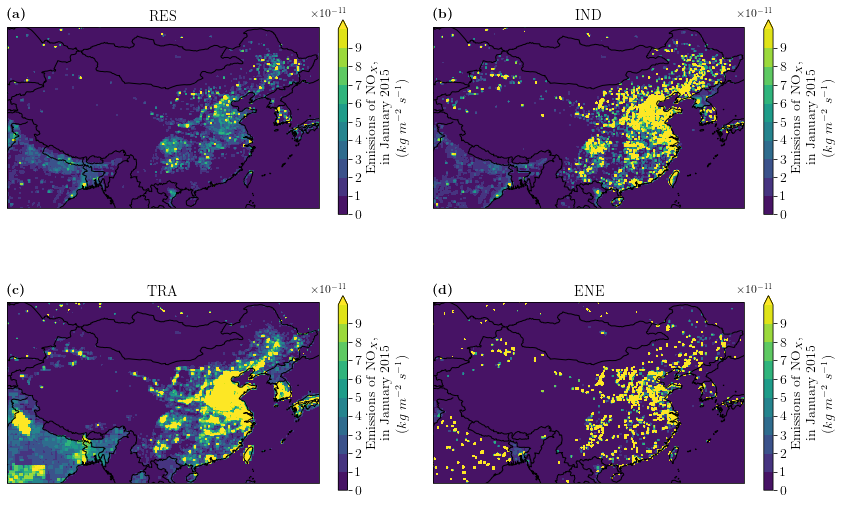

In [224]:
fig = plt.figure(1, figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)

specie = 'NOx' # also check SO2 and VOC
sectors = ['RES', 'IND', 'TRA', 'ENE']
for index, sector in enumerate(sectors):
    make_plot(index, emissions_all, sector, specie, 'all')

gs.tight_layout(fig, rect=[0, 0, 1, 0.8])

#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emissions_jan_china_{specie}.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emissions_jan_china_{specie}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

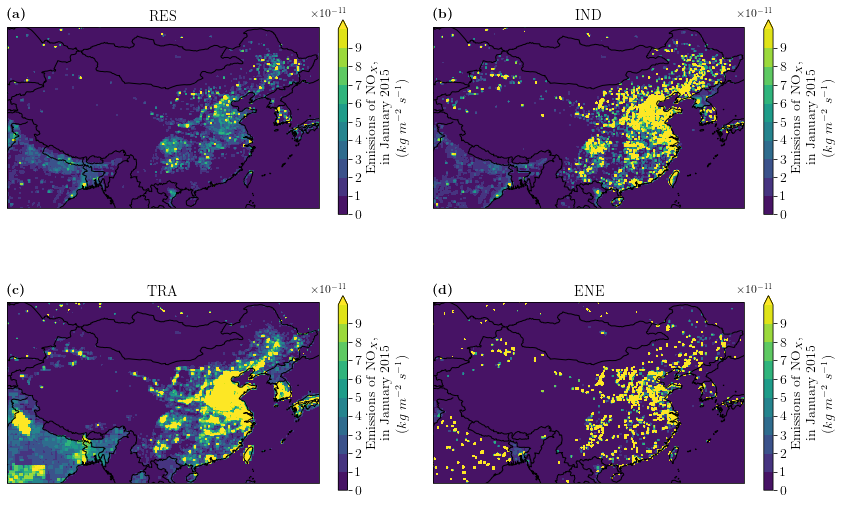

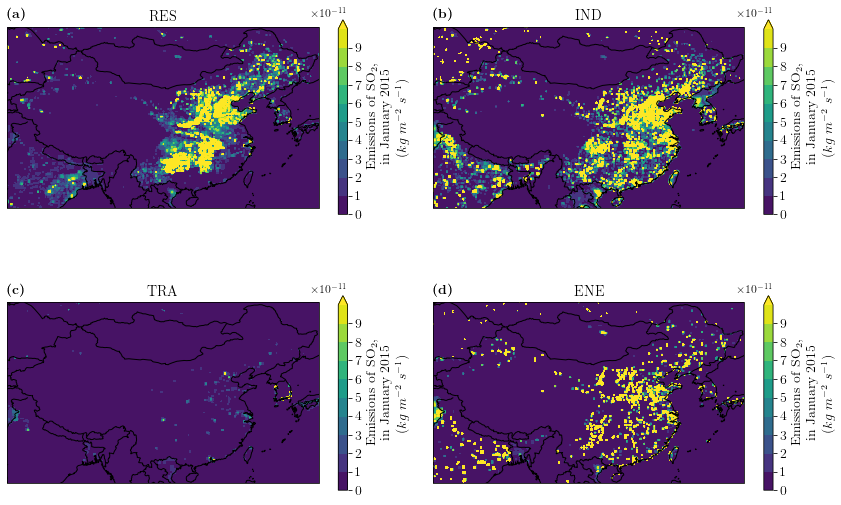

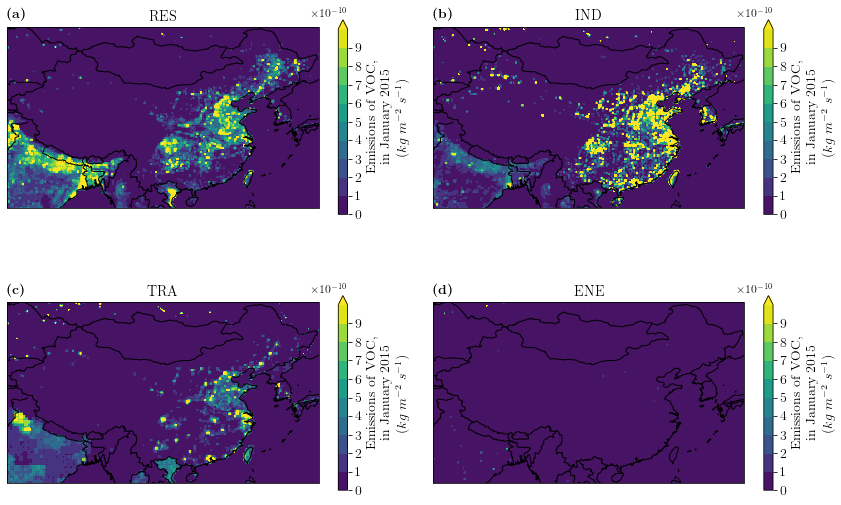

In [225]:
region = 'all'

for specie in ['NOx', 'SO2', 'VOC']: # ['BC', 'OC', 'PM2.5', 'PM10', 'CO', 'NH3', 'NOx', 'SO2', 'VOC']
    if specie != 'NH3' and specie != 'VOC':
        sectors = ['RES', 'IND', 'TRA', 'ENE']
        
        fig = plt.figure(1, figsize=(12, 12))
        gs = gridspec.GridSpec(2, 2)

        for index, sector in enumerate(sectors):
            if region == 'all':
                make_plot(index, emissions_all, sector, specie, region)
            elif region == 'China':
                make_plot(index, emissions, sector, specie, region)

        gs.tight_layout(fig, rect=[0, 0, 1, 0.8])

        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emissions_{region}_{specie}.png', dpi=700, alpha=True, bbox_inches='tight')
        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emissions_{region}_{specie}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
        plt.show()
        
    elif specie == 'NH3':
        sectors = ['RES', 'IND', 'TRA', 'AGR']
        
        fig = plt.figure(1, figsize=(12, 12))
        gs = gridspec.GridSpec(2, 2)

        for index, sector in enumerate(sectors):
            if region == 'all':
                make_plot(index, emissions_all, sector, specie, region)
            elif region == 'China':
                make_plot(index, emissions, sector, specie, region)

        gs.tight_layout(fig, rect=[0, 0, 1, 0.8])

        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emissions_{region}_{specie}.png', dpi=700, alpha=True, bbox_inches='tight')
        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emissions_{region}_{specie}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
        plt.show()
        
    elif specie == 'VOC':
        sectors = ['RES', 'IND', 'TRA', 'ENE']
        
        fig = plt.figure(1, figsize=(12, 12))
        gs = gridspec.GridSpec(2, 2)

        for index, sector in enumerate(sectors):
            if region == 'all':
                make_plot(index, emissions_all, sector, specie, region)
            elif region == 'China':
                make_plot(index, emissions, sector, specie, region)

        gs.tight_layout(fig, rect=[0, 0, 1, 0.8])

        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emissions_{region}_{specie}.png', dpi=700, alpha=True, bbox_inches='tight')
        plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emissions_{region}_{specie}.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
        plt.show()